In [30]:
#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

In [31]:
train_data_dir = 'dataset/training'

filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    f_path = os.path.join(train_data_dir , fold)
    if os.path.isdir(f_path):
        filelists = os.listdir(f_path)

        for file in filelists:
            filepaths.append(os.path.join(f_path , file))
            labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'labels')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [32]:
test_data_dir = 'dataset/testing'

filepaths = []
labels = []

folds = os.listdir(test_data_dir)

for fold in folds:
    f_path = os.path.join(test_data_dir , fold)
    if os.path.isdir(f_path):
        filelists = os.listdir(f_path)

        for file in filelists:
            filepaths.append(os.path.join(f_path , file))
            labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'labels')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [33]:
# valid, test = train_test_split(test_df, train_size = 0.5, shuffle = True, random_state= 42)
valid , test = train_test_split(test_df , test_size = 0.5 , shuffle = True , stratify = test_df['labels'] , random_state = 42)

In [34]:
img_size = (224 ,244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


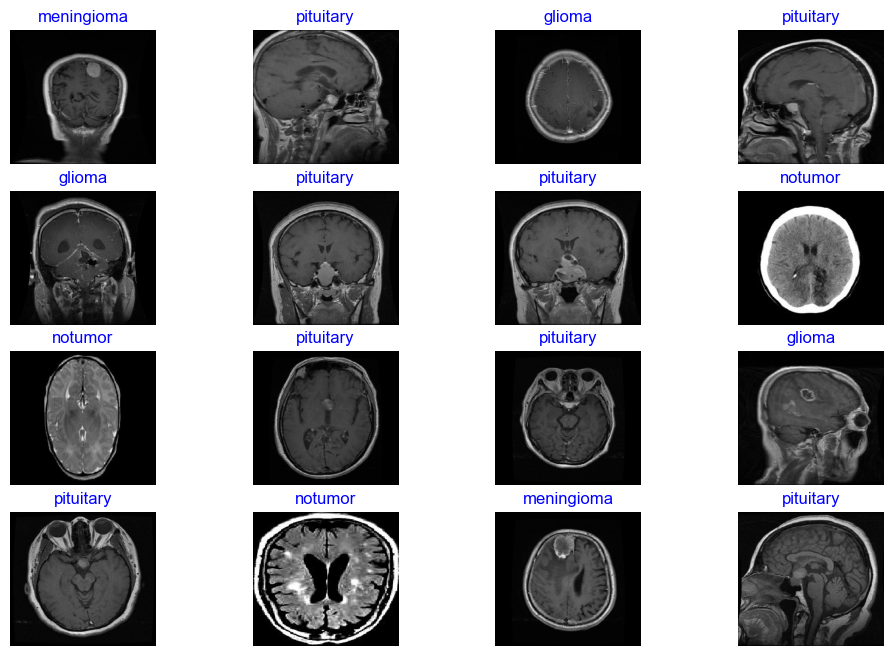

In [55]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize = (12 , 8))
for i in range(16):
    plt.subplot(4 , 4 , i+1)
    image = images[i]/255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

In [36]:
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top = False , weights = 'imagenet',
    input_shape = img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,253,396 (23.85 MB)

 Trainable params: 6,190,228 (23.61 MB)

 Non-trainable params: 63,168 (246.75 KB)

In [56]:
Epochs = 10

history = model.fit(
    train_gen,
    epochs = Epochs,
    verbose = 1,
    validation_data = valid_gen,
    shuffle = True
)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 395s 1s/step - accuracy: 0.4982 - loss: 3.6279 - val_accuracy: 0.5893 - val_loss: 2.8848
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.6259 - loss: 2.4780 - val_accuracy: 0.7267 - val_loss: 2.0385
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 425s 1s/step - accuracy: 0.6807 - loss: 1.8193 - val_accuracy: 0.7511 - val_loss: 1.5576
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 407s 1s/step - accuracy: 0.7251 - loss: 1.4099 - val_accuracy: 0.7710 - val_loss: 1.1854
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 402s 1s/step - accuracy: 0.7985 - loss: 1.1263 - val_accuracy: 0.9069 - val_loss: 0.9607
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - accuracy: 0.8596 - loss: 0.9308 - val_accuracy: 0.9359 - val_loss: 0.7408
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.8766 - loss: 0.8155 - val_accuracy: 0.9527 - val_loss: 0.6308
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - accuracy: 0.9016 - loss: 0.7308 - val_accu

In [5]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

NameError: name 'history' is not defined

In [4]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

NameError: name 'model' is not defined

In [59]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds , axis = 1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 268ms/step


In [3]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

NameError: name 'test_gen' is not defined

In [1]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

NameError: name 'classification_report' is not defined

In [2]:
model.save("model.h5")

NameError: name 'model' is not defined

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

In [ ]:
model = load_model('model.h5', compile=False)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
gambar = tf.keras.preprocessing.image.load_img('/dataset/Testing/glioma/Te-glTr_0000.jpg', target_size=img_size)

In [ ]:
input_arr = tf.keras.preprocessing.image.img_to_array(gambar)

In [ ]:
input_arr = np.array([input_arr])
prediksi = model.predict(input_arr)
predicted_class = np.argmax(prediksi, axis=-1)

In [ ]:
print(classes)

In [ ]:
print(predicted_class)

In [ ]:
names = [classes[i] for i in predicted_class]
print(names)